In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")

Skipping, found downloaded files in "../datasets/usa-real-estate-dataset" (use force=True to force download)


#### Functions

In [2]:
# Removing outliers
def find_outliers(col):

    Q1, Q3 = col.describe()[["25%", "75%"]]
    IQR = Q3 - Q1
    high = Q3 + IQR * 1.5
    low = Q1 - IQR * 1.5
    is_outliar = col.map(lambda x: x > high or x < low)
    print(f"Found {(is_outliar).sum()} outliers")

    return is_outliar

def cv_calc(model, X, y, cv=5):
    
    t1 = time.time()
    scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="neg_mean_squared_error"))
    t2 = time.time() - t1
    calc_time = round(t2,2)
    scores = round(np.mean(scores),5)

    print(f"Cross validation Mean squared error: {scores}\nTime: {calc_time}s")

    return calc_time, scores

### EDA

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "realtor-data.csv"))
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          100000 non-null  object 
 1   bed             75050 non-null   float64
 2   bath            75112 non-null   float64
 3   acre_lot        85987 non-null   float64
 4   city            99948 non-null   object 
 5   state           100000 non-null  object 
 6   zip_code        99805 non-null   float64
 7   house_size      75082 non-null   float64
 8   prev_sold_date  28745 non-null   object 
 9   price           100000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 7.6+ MB


In [5]:
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,75050.000000,75112.000000,85987.000000,99805.000000,7.508200e+04,1.000000e+05
mean,3.701013,2.494595,13.613473,2132.003467,2.180082e+03,4.383656e+05
std,2.091372,1.573324,840.143878,2455.654774,5.625349e+03,1.015773e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,4.450000e+02
25%,3.000000,2.000000,0.190000,971.000000,1.200000e+03,1.250000e+05
50%,3.000000,2.000000,0.510000,1225.000000,1.728000e+03,2.650000e+05
75%,4.000000,3.000000,2.000000,1611.000000,2.582000e+03,4.749000e+05
max,86.000000,56.000000,100000.000000,99999.000000,1.450112e+06,6.000000e+07


In [6]:
df.describe(include='O').T

,count,unique,top,freq
status,100000,2,for_sale,99819
city,99948,525,San Juan,4788
state,100000,12,Massachusetts,52694
prev_sold_date,28745,3604,2019-10-01,83


In [7]:
df.isnull().sum()

status                0
bed               24950
bath              24888
acre_lot          14013
city                 52
state                 0
zip_code            195
house_size        24918
prev_sold_date    71255
price                 0
dtype: int64

In [8]:
# Status seems irrelevant , prev_sold_date 71% missing values
df.drop(columns=["status", "prev_sold_date", "zip_code"], inplace=True)

In [9]:
print(df.state.value_counts())

state
Massachusetts     52694
Puerto Rico       24679
Connecticut       12178
Virgin Islands     2573
Rhode Island       2401
New Hampshire      2232
New York           1874
Vermont            1324
South Carolina       24
Tennessee            16
Virginia              3
New Jersey            2
Name: count, dtype: int64


In [10]:
# Drop states with low sample size
print(df.shape)
df = df.loc[~df.state.isin(["South Carolina", "Tennessee", "Virginia", "New Jersey"]), :]
print(df.shape)

(100000, 7)
(99955, 7)


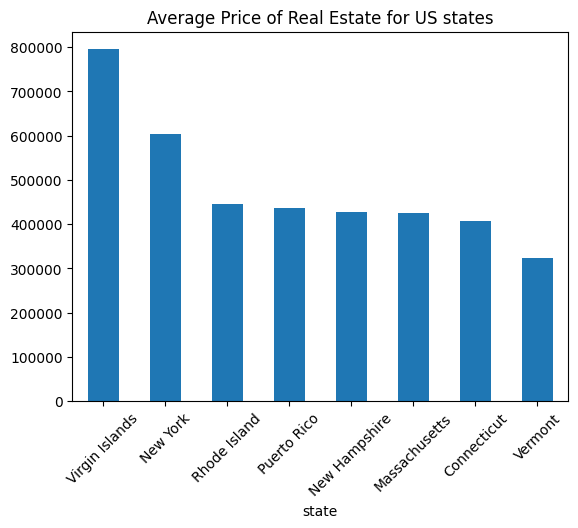

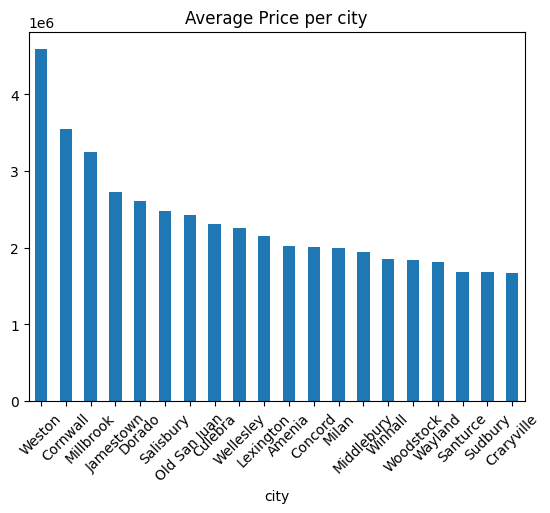

In [11]:
df.groupby('state').price.mean().sort_values(ascending=False).plot.bar()
plt.title('Average Price of Real Estate for US states')
plt.xticks(rotation=45)
plt.show()
df.groupby('city').price.mean().sort_values(ascending=False).head(20).plot.bar()
plt.title('Average Price per city')
plt.xticks(rotation=45)
plt.show()

From the output of <b>.describe()</b> we see that we have outliars. I will remove them using the rule anything outside the interval <b>[Q1 - interquartile range * 1.5,  Q3 + interquartile range * 1.5]</b> is an outliar. Running this in an iterative manner for every column gives better performance compared to precalculating them for each column before removing the outliars.

In [12]:
print(df.shape)
for c in ["bed", "bath", "acre_lot", "house_size", "price"]:
    print(f"checking {c}")
    
    df = df.loc[~find_outliers(df[c]), :]
print(df.shape)

(99955, 7)
checking bed
Found 10589 outliers
checking bath
Found 2131 outliers
checking acre_lot
Found 11063 outliers
checking house_size
Found 2232 outliers
checking price
Found 3358 outliers
(70582, 7)


#### Plots after cleaning

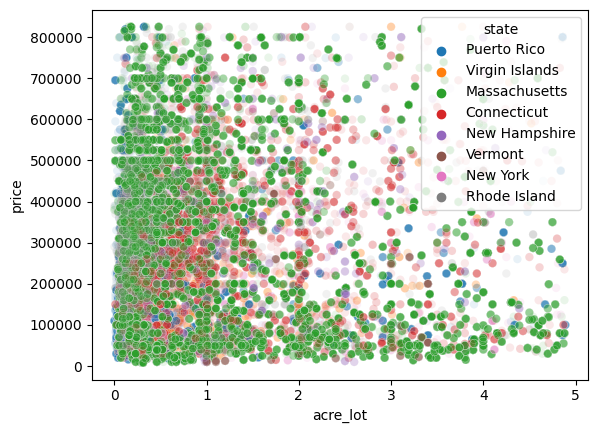

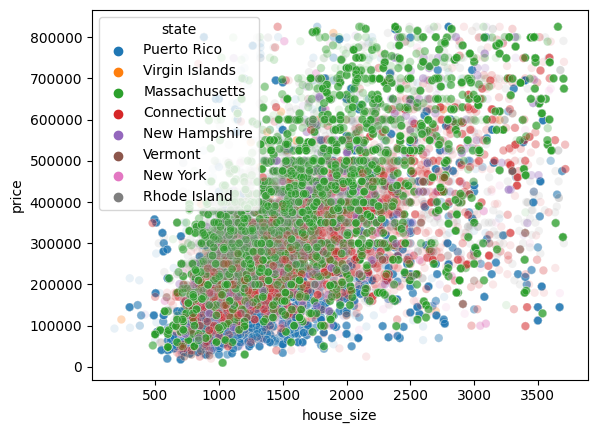

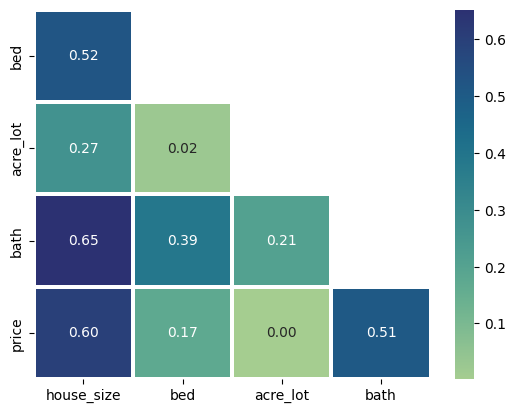

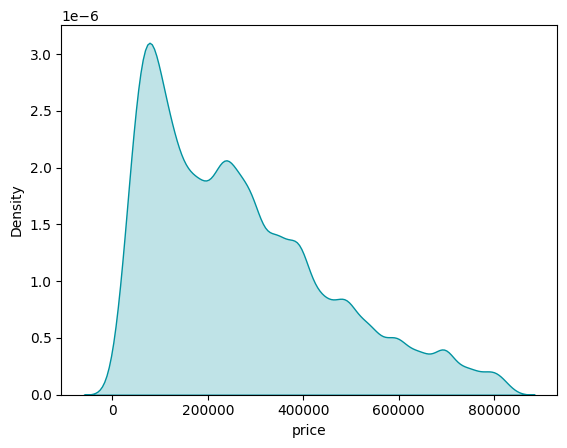

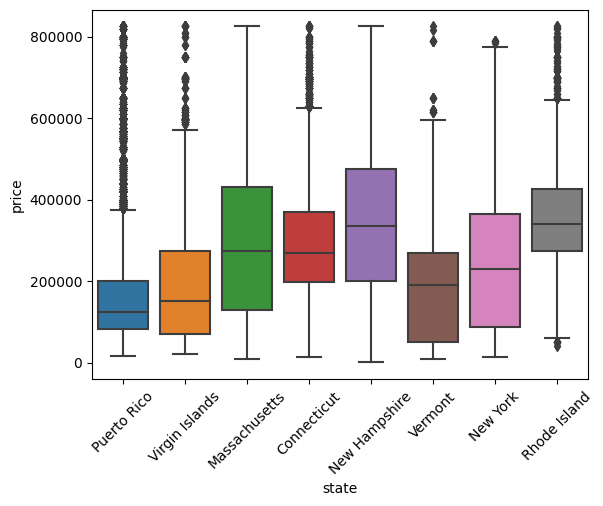

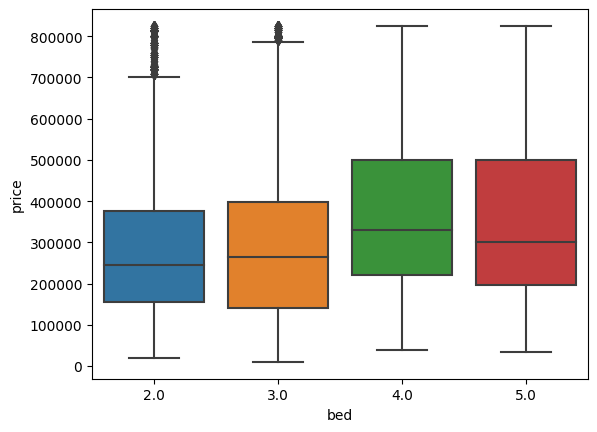

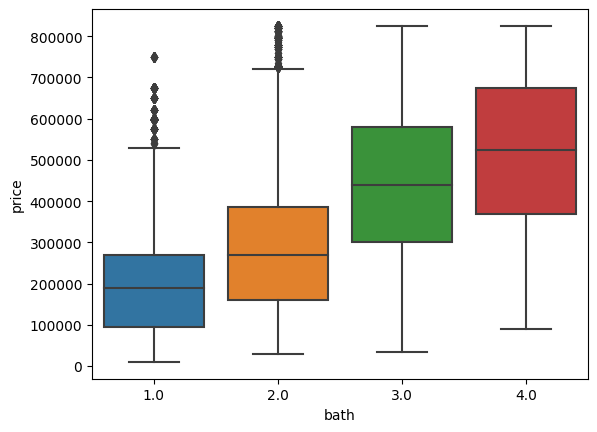

In [13]:
sns.scatterplot(df, x="acre_lot", y="price", hue="state", alpha=0.1)
plt.show()
sns.scatterplot(df, x="house_size", y="price", hue="state", alpha=0.1)
plt.show()
corr_mat = df[["house_size", "bed", "acre_lot", "bath", "price"]].corr()
mask = np.triu(np.ones_like(corr_mat)).astype(bool)
mask = mask[1:, :-1]
corr_mat = corr_mat.iloc[1:,:-1]
sns.heatmap(corr_mat, annot=True, linewidth=1.5, fmt=".2f", cmap="crest", mask=mask)
plt.show()
sns.kdeplot(df["price"], fill=True, color="#0092A0")
plt.show()
sns.boxplot(df, x="state", y="price")
plt.xticks(rotation=45)
plt.show()
sns.boxplot(df, x="bed", y="price")
plt.show()
sns.boxplot(df, x="bath", y="price")
plt.show()

Looks like number of bathrooms and house size have a correlation with the price which is an expected result and should have strong predictive power.
Acre_lot - Price scatter plot doesn't reveal any obvious pattern. There is no obvious pattern for acre_lot. Also states are having different price distributions which is something I might be able to use.

## Models

In [14]:
metrics = {}


df_train, df_test = train_test_split(df, test_size=0.2, random_state=47, stratify=df["state"].tolist())

### Dropping all NaN values

In [15]:
# Drop rows that have at least one null value
print("Dataframe size before dropna:", df.shape)
df_train_dropna_all = df.dropna()
print("Dataframe size after dropna:", df_train_dropna_all.shape)

Dataframe size before dropna: (70582, 7)
Dataframe size after dropna: (43319, 7)


In [16]:
df_train_dropna_all.shape

(43319, 7)

In [17]:
# Split features and labels
X_dropna_all = df_train_dropna_all.drop(columns=["price"])
y_dropna_all = df_train_dropna_all["price"].copy()

<h5>Only with numerical columns</h5>

In [18]:
X_dropna_all_num = X_dropna_all.select_dtypes(exclude=["object"])

RandomForest

In [19]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_num, y_dropna_all)
metrics["forest_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 60811.62579
Time: 2.0s


Ridge regression

In [20]:
# Ridge regression
l2_reg = Ridge(random_state=47)
calc_time, score = cv_calc(l2_reg, X_dropna_all_num, y_dropna_all)
metrics["ridge_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 141537.93807
Time: 0.37s


CatBoost

In [21]:
# Catboost
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_num, y_dropna_all)
metrics["catboost_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 105767.40433
Time: 8.73s


<h5>Adding categorical columns</h5>

RandomForest

In [22]:
X_dropna_all_oh = pd.get_dummies(X_dropna_all)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_oh, y_dropna_all)
metrics["forest_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 45710.17529
Time: 23.31s


CatBoost

In [23]:
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_oh, y_dropna_all)
metrics["catboost_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 73307.76373
Time: 15.95s


<h3> Fillnas </h3>

In [24]:
# fillnas
df_train_imp = df_train.dropna(subset=["city", "state", "price"])

df_train_imp.loc[:, "bed"] = df_train_imp["bed"].fillna(df_train_imp.groupby("city").bed.transform("median").transform("round"))
df_train_imp.loc[:, "bath"] = df_train_imp["bath"].fillna(df_train_imp.groupby("city").bath.transform("median").transform("round"))
df_train_imp.loc[:, "acre_lot"] = df_train_imp["acre_lot"].fillna(df_train_imp.groupby("city").acre_lot.transform("median"))
df_train_imp.loc[:, "house_size"] = df_train_imp["house_size"].fillna(df_train_imp.groupby("city").house_size.transform("median"))

df_train_imp = df_train_imp.dropna()
X_imp = df_train_imp.drop(columns=["price"])
y_imp = df_train_imp["price"].copy()

<h4>Only numerical columns</h4>

Random forest

In [25]:
X_imp_num = X_imp.select_dtypes(exclude=["object"])

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_num, y_imp)
metrics["forest_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 49837.87286
Time: 1.93s


CatBoost

In [26]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_num, y_imp)
metrics["catboost_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 108415.5319
Time: 9.97s


<h4>All data with one hot for categorical</h4>

RandomForest

In [27]:
X_imp_oh = pd.get_dummies(X_imp)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_oh, y_imp)
metrics["forest_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 37585.2355
Time: 61.75s


CatBoost

In [28]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_oh, y_imp)
metrics["catboost_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 86332.55837
Time: 19.87s


<b>Feature scaling</b>

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_imp_num = X_imp.select_dtypes(exclude=["object"])
X_imp_obj = X_imp.select_dtypes(exclude=["float64"])
X_temp = scaler.fit_transform(X_imp_num)
X_imp_num = pd.DataFrame(X_temp, columns=X_imp_num.columns.tolist())
X_imp_scaled = X_imp_num.join(X_imp_obj) 
X_imp_scaled_oh = pd.get_dummies(X_imp_scaled)

RandomForest

In [30]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_scaled_oh, y_imp)
metrics["forest_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 54710.72798
Time: 40.32s


CatBoost

In [31]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_scaled_oh, y_imp)
metrics["catboost_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 115265.2519
Time: 16.62s


<b>Adding clusters</b>

In [32]:
km = KMeans(n_clusters=7)
X = X_imp.join(y_imp).loc[: , ["bed", "bath", "house_size"]]
X["cluster"] = km.fit_predict(X)
X.loc[:, "cluster"] = X["cluster"].astype("category")
X_imp_cls = X_imp.copy()
X_imp_cls["cluster"] = X["cluster"]
X_imp_cls_oh = pd.get_dummies(X_imp_cls)

/home/olaf/.cache/pypoetry/virtualenvs/ml-with-scikit-learn-tVW5DHEw-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='house_size', ylabel='price'>

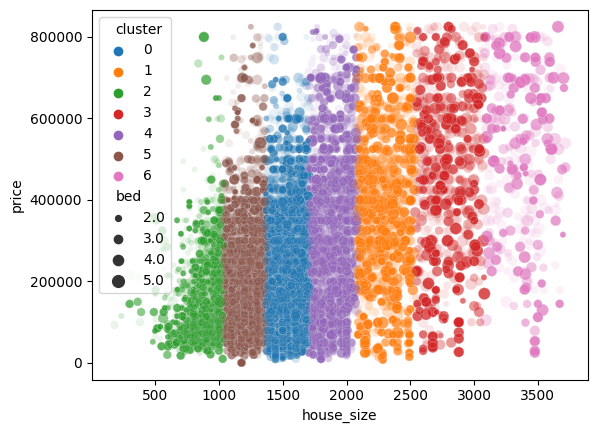

In [33]:
sns.scatterplot(x="house_size", y="price", hue="cluster", alpha=0.1, size="bed", data=X_imp_cls.join(y_imp))

In [34]:
forest = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest, X_imp_cls_oh, y_imp)
metrics["forest_cluster"] = {"time": calc_time, "score": score}


Cross validation Mean squared error: 37691.03855
Time: 62.84s


### Model optimization

In [34]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
forest_fillna_oh,60.49,37585.23550
forest_dropna_oh,22.90,45710.17529
forest_fillna_num,1.93,49837.87286
forest_fillna_scaled,40.14,54710.72798
forest_dropna_num,1.96,60811.62579
catboost_dropna_oh,16.15,73307.76373
catboost_fillna_oh,20.42,86332.55837
catboost_dropna_num,8.32,105767.40433
catboost_fillna_num,10.13,108415.53190
catboost_fillna_scaled,16.76,115265.25190


In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_dropna_all_num, y_dropna_all)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_dropna_all_num.columns)
mi_scores.sort_values(ascending=False)

house_size    4.188811
acre_lot      2.440356
bath          0.399550
bed           0.305886
Name: MI Scores, dtype: float64